# Introduction to DL NLP with BoW

In this tutorial, we will cover:

- Simple BoW model on ready processed `keras.datasets.imdb`.
- NLP data pre-processing on `aclimbd` raw data set.
- Text binarization using keras `Tokenizer`
- Text features using both sklearn and keras Tokenizer: `binary`, `count`, `freq` and `tfidf`
- Introduce Keras `Embedding` layer and how to use it with Bag-of-word vectors model.

In [ ]:
from keras.datasets import imdb
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer  
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import numpy as np
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Classifying movie reviews with BoW model

__Core ideas:__

1- How text is represented in ML/DL (vocab)

2- Simple Dense keras model

3- Binary classification loss and activation

## The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to 
train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and 
what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously 
you don't need your model to predict those). For instance, it is possible that your model could end up merely _memorizing_ a mapping between 
your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before. 
We will go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [ ]:


(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step



The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words 
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). 
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [ ]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [ ]:
train_labels[0]

1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [ ]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here's how you can quickly decode one of these reviews back to English words:

In [ ]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

# Bag of Words

The term BoW is used in many different occasions in NLP. In general, it referes to treating every word equally as the others, without consideration of sequential information of the sentence or document. In other words, the context of the words is not considered. 

In some settings, words in the bag are summed, averaged,...etc (or their vectors). In other settings, they are simply mutlipled by different _learnable_ weighting. This is the case we will consider. We will use the `Dense` layer, applied to a _long_ vector of 1's and 0's. The length of that vector is the same as the number of words in our vocab (we specified when loading the data above using the `num_words` param). We will have such vector for every sentence/document of the data. Whenever a word of the vocab is mentioned, we set the corresponding location to 1. Otherwise, it's 0. 

__You can imagine how sparse and inefficient is that vector!__

__In this setting, we are treating the mention or absence of a word as a feature__

The `Dense` layer will assign a _learnable_ weight to each word location. If the word is mentioned, that weight will be multiplied by 1, else it's 0. Then the output of the `Dense` is a number of neurons (hyper param), each represents different weighting of the input long vector of features/words.

The next layers, are just further _refinements_ of the learnt features from the previous layers. Until we reach the final layer, which produces 1 or k outputs according to the problem or task (binary or multi classification).

__Pros__:
- All words are normalized, regardless of their index in the vocab

__Cons__:

- Sparsity = inefficiency = A lot of useless features = confusion of the model = unnecessary big model = more overfitting

- Need to pad to max (again inefficiency): 

This model, requires ALL the data samples to have the same length, sense the `Dense` layer cannot handle variable length input (weight matrix is fixed). This mandates to perform padding

- No context = no sequence = hard to model co-reference, sarcasm, negation...etc

_Example_

Such BoW model has no clue to differentiate the following cases:

- This movie is good --> +

- This movie is bad --> -

- This movie is not good --> -

- This movie is not bad --> +

Simple because it cannot link the context of the words "good" and "bad" to the negatition or affirmation context "not"



## Preparing the data


We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`, 
then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding` layer, which we will cover in 
detail later).
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence 
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as 
first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [ ]:


def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [ ]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize our labels, which is straightforward:

In [ ]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now our data is ready to be fed into a neural network.

## Building our network


Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of 
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16, 
activation='relu')`

The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension 
in the representation space of the layer. You may remember from the previous chapter that each such `Dense` layer with a `relu` activation implements 
the following chain of tensor operations:

`output = relu(dot(W, input) + b)`

Having 16 hidden units means that the weight matrix `W` will have shape `(input_dimension, 16)`, i.e. the dot product with `W` will project the 
input data onto a 16-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). You can 
intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when 
learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more 
complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that 
will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

In the next chapter, you will learn formal principles to guide you in making these choices. 
For the time being, you will have to trust us with the following architecture choice: 
two intermediate layers with 16 hidden units each, 
and a third layer which will output the scalar prediction regarding the sentiment of the current review. 
The intermediate layers will use `relu` as their "activation function", 
and the final layer will use a sigmoid activation so as to output a probability 
(a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). 
A `relu` (rectified linear unit) is a function meant to zero-out negative values, 
while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

And here's the Keras implementation, very similar to the MNIST example you saw previously:

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network 
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. 
It isn't the only viable choice: you could use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when you 
are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" 
between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will 
also monitor accuracy during training.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We are passing our optimizer, loss function and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy` and 
`accuracy` are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer, or pass a custom loss 
function or metric function. This former can be done by passing an optimizer class instance as the `optimizer` argument:

In [ ]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

The latter can be done by passing function objects as the `loss` or `metrics` arguments:

In [ ]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by 
setting apart 10,000 samples from the original training data:

In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the 
validation data as the `validation_data` argument:

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))




Train on 15000 samples, validate on 10000 samples
Epoch 1/20





15000/15000 [==============================] - 3s 168us/step - loss: 0.4851 - binary_accuracy: 0.7859 - val_loss: 0.3666 - val_binary_accuracy: 0.8624
Epoch 2/20
15000/15000 [==============================] - 2s 126us/step - loss: 0.2838 - binary_accuracy: 0.9057 - val_loss: 0.3060 - val_binary_accuracy: 0.8791
Epoch 3/20
15000/15000 [==============================] - 2s 131us/step - loss: 0.2112 - binary_accuracy: 0.9307 - val_loss: 0.3024 - val_binary_accuracy: 0.8770
Epoch 4/20
15000/15000 [==============================] - 2s 129us/step - loss: 0.1663 - binary_accuracy: 0.9464 - val_loss: 0.2941 - val_binary_accuracy: 0.8818
Epoch 5/20
15000/15000 [==============================] - 2s 128us/step - loss: 0.1350 - binary_accuracy: 0.9571 - val_loss: 0.3289 - val_binary_accuracy: 0.8735
Epoch 6/20
15000/15000 [==============================] - 2s 130us/step - loss: 0.1127 - binary_accuracy: 0.9642 - val_loss: 0.3019 

On CPU, this will take less than two seconds per epoch -- training is over in 20 seconds. At the end of every epoch, there is a slight pause 
as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data 
about everything that happened during training. Let's take a look at it:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the 
training and validation loss side by side, as well as the training and validation accuracy:

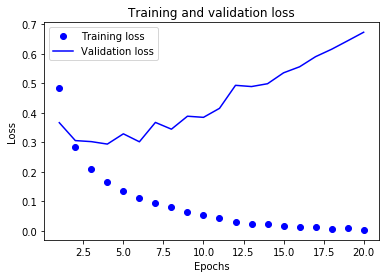

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

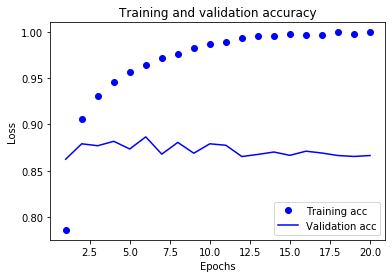

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Classifying movie reviews from scratch

So far, we have used the processed IMDB dataset in `keras`. As you have seen, for text to be "usable" in a DNN, we need to transform it into digital form, i.e. integers not strings.

In the basic BoW Dense model, we treat every word as a _feature_

Moreover, for neurons (or ML features in general), we need normalized values [0,1]. Otherwise, words with higher index will be interpretted as higher features importance.

In `keras.datasets.imdb` this digitization was readily made for us. We could see the data represented as numbers:

However, the raw [IMDB](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz ) is just plain text:

In [ ]:
from pathlib import Path
import os
DATA_PATH=Path('./dat/')
DATA_PATH.mkdir(exist_ok=True)
#if not os.path.exists('./dat/aclImdb_v1.tar.gz'):
if not os.path.exists('./dat/aclImdb'):
    !curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
    !tar -xf aclImdb_v1.tar.gz -C {DATA_PATH}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.4M      0  0:00:07  0:00:07 --:--:-- 17.2M


The data is already split into train/test. Moreover, we have 3 class folders:

- pos

- neg

- unsup (no specific label)

Let's have a look on the raw data:

In [ ]:
import numpy as np
CLASSES = ['neg', 'pos']#, 'unsup']
PATH=Path('./dat/aclImdb/')

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            #texts.append(fixup(fname.open('r', encoding='utf-8').read()))
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    #return np.array(texts),np.array(labels)
    return texts, labels


In [ ]:

trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

In [ ]:
for t in trn_texts[:10]:
  print(t)
  print('\n')

Bonfires of the Vanities is a film drenched in flop sweat. I can recall no film that has tried so hard to be so unrelentingly outrageous, provocative and important, yet failed so consistently across the board. It is like a stand up comic who's not getting laughs, but can't leave the stage. The harder the film tries, the louder each attempt at a laugh results in a resounding thud. The desperation the film displays is so glaring it almost rouses pity for all those involved.<br /><br />The film achieves laugh-out-loud status only twice. Once is in the sight of Geraldo Rivera playing an obnoxious, arrogant and amoral TV tabloid journalist -- which is funny only because he apparently doesn't realize he is playing himself. The other scene that deserves to be laughed at is the film's final "big moment," wherein the judge played by Morgan Freeman delivers the sanctimonious lecture about what morality is ("it's what your mama taught ya!"). The pomposity of the moment is insulting to the point o

# So what it takes to go from the raw form to the prepared form?

__A - Text preprocessing__

1- Data sequencing: each sentence --> sequence (list) of words

2- Data cleaning: This step varies from task to task. For some tasks it's better to remove special characters and punctuations, for other they are critical (emotiocons). Good for perfromance.

3- Text normalization: in general text morphology is a big issue in NLP. Upper and lower cases, stemming and lemmatization, ...etc. Again it's task dependent.

4- Padding (model dependent): Dense and CNN. RNN can skip this step.

__B- Text preparation__

5- Binarization/vectorization/digitization: transform words into numbers according to a vocab index.

Let's start with the first phase:

# Text preprocessing

In this phase, we apply some operations on the text, to make it in the most usable form for the task at hand. Mainly we clean it up to be more appealing to the problem we try to solve. The input is __text__ and the output is a transformed __text__.

# Splitting text into sequence

## Manual (split on white spaces)

In [ ]:
s = trn_texts[0]
s.split()

['Bonfires',
 'of',
 'the',
 'Vanities',
 'is',
 'a',
 'film',
 'drenched',
 'in',
 'flop',
 'sweat.',
 'I',
 'can',
 'recall',
 'no',
 'film',
 'that',
 'has',
 'tried',
 'so',
 'hard',
 'to',
 'be',
 'so',
 'unrelentingly',
 'outrageous,',
 'provocative',
 'and',
 'important,',
 'yet',
 'failed',
 'so',
 'consistently',
 'across',
 'the',
 'board.',
 'It',
 'is',
 'like',
 'a',
 'stand',
 'up',
 'comic',
 "who's",
 'not',
 'getting',
 'laughs,',
 'but',
 "can't",
 'leave',
 'the',
 'stage.',
 'The',
 'harder',
 'the',
 'film',
 'tries,',
 'the',
 'louder',
 'each',
 'attempt',
 'at',
 'a',
 'laugh',
 'results',
 'in',
 'a',
 'resounding',
 'thud.',
 'The',
 'desperation',
 'the',
 'film',
 'displays',
 'is',
 'so',
 'glaring',
 'it',
 'almost',
 'rouses',
 'pity',
 'for',
 'all',
 'those',
 'involved.<br',
 '/><br',
 '/>The',
 'film',
 'achieves',
 'laugh-out-loud',
 'status',
 'only',
 'twice.',
 'Once',
 'is',
 'in',
 'the',
 'sight',
 'of',
 'Geraldo',
 'Rivera',
 'playing',
 'an'

__Notice how punctuation is preserved!__

Do we care to have 'movie.', instead of 'movie.' or 'movie,'?

Actually we do!

As you have already had an idea from previous excercise on clean IMDB, we use vocabulary to binarize the words (word2index).

Having such punctuations mandates that we have 2 entries in the vocab for the word movie. This has 2 issues:

1- Increased vocab size--> sparse features and more memory

2- What other forms we account for: 'movie!', 'movie:',...etc. Those are different and unexpected morphologies.

__Remember, we aim at normalizing the text to common format as much as possible (like lower)__

## Using regex

We could escape this trap by keeping only the words, using a regex:

In [ ]:

re.split(r'\W+', s)

['Bonfires',
 'of',
 'the',
 'Vanities',
 'is',
 'a',
 'film',
 'drenched',
 'in',
 'flop',
 'sweat',
 'I',
 'can',
 'recall',
 'no',
 'film',
 'that',
 'has',
 'tried',
 'so',
 'hard',
 'to',
 'be',
 'so',
 'unrelentingly',
 'outrageous',
 'provocative',
 'and',
 'important',
 'yet',
 'failed',
 'so',
 'consistently',
 'across',
 'the',
 'board',
 'It',
 'is',
 'like',
 'a',
 'stand',
 'up',
 'comic',
 'who',
 's',
 'not',
 'getting',
 'laughs',
 'but',
 'can',
 't',
 'leave',
 'the',
 'stage',
 'The',
 'harder',
 'the',
 'film',
 'tries',
 'the',
 'louder',
 'each',
 'attempt',
 'at',
 'a',
 'laugh',
 'results',
 'in',
 'a',
 'resounding',
 'thud',
 'The',
 'desperation',
 'the',
 'film',
 'displays',
 'is',
 'so',
 'glaring',
 'it',
 'almost',
 'rouses',
 'pity',
 'for',
 'all',
 'those',
 'involved',
 'br',
 'br',
 'The',
 'film',
 'achieves',
 'laugh',
 'out',
 'loud',
 'status',
 'only',
 'twice',
 'Once',
 'is',
 'in',
 'the',
 'sight',
 'of',
 'Geraldo',
 'Rivera',
 'playing',


This is better. But imagine have the following:



In [ ]:
s = 'human-like robots are dump'
re.split(r'\W+', s)

['human', 'like', 'robots', 'are', 'dump']

This is completely opposite meaning!!

In [ ]:
s = "What's on your mind?"
re.split(r'\W+', s)

['What', 's', 'on', 'your', 'mind', '']

The 's is split.

Also the ? is removed!

Removing punctuations altogether is not what we want.

For sentiment for example, those symbols might be the reason of classfication:

- 'What a moview :)'

- 'What a movie!'



## Split by white spaces and remove punctuations

For the example above, if we want to keep 'What's' but get rid of the punctuations like ? we can use regex to filter punctuations.

We can use:

In [ ]:

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
# remove punctuation from each word
s = "What's on your mind?"
stripped = [re_punc.sub('', w) for w in s.split()]
stripped

['Whats', 'on', 'your', 'mind']

In [ ]:
s = 'human-like robots are dump'
stripped = [re_punc.sub('', w) for w in s.split()]
stripped

['humanlike', 'robots', 'are', 'dump']

See how human-like is translated into humanlike, which somehow keeps the meaning.

# Case normalization

One of the important and easy normalization is to convert all case to common case. Mostly lower case. This has the effect of reducing the vocabulary size, and also reduct Out-Of-Vocab (OOV).

For example, if our vocab is as follows:

In [ ]:
v = {'the':1, 'cat':2, 'mat':3}

Now if we try to binarize the following sentence:

In [ ]:
s = 'The CAT sat on the mat'


In [ ]:
x = [v[w] for w in s.split()]
x

KeyError: ignored

To avoid OOV, we can add special term: '_UNK_' for unknown words:

In [ ]:
v = {'the':1, 'cat':2, 'sat': 3, 'on': 4, 'mat':5}

In [ ]:
x = []

for w in s.split():
  if w in v:
    x.append(v[w])
  else:
    x.append(0)
x    

[0, 0, 3, 4, 1, 5]

As you can see, 'The' and 'Cat' are mapped as UNK. While they are already in the vocab.

To workaround this, we try to get all the text to a common morphology:

In [ ]:
x = []

for w in s.lower().split():
  if w in v:
    x.append(v[w])
  else:
    x.append(0)
x 

[1, 2, 3, 4, 1, 5]

But sometimes, this simple normalization might remove some semantics. For example in sentiment, captiatlization might reflect certain negative emotion/sentiment:

_WHAT are you doing?_

## NLTK

So far, we have split the words using manual approaches (white spaces mainly).

Is there more mature method?

Actually there is: __tokenizers__

The most basic tokenizers take care of punctuation (although we already handled with regex above), and other splitting criteria.

NLTK can be used for that.

## Sentence tokenization

Before we dive into words splitting, let's talk a little about sentence tokenization. Sometimes, the data comes in very long bult of text, a document or long paragraphs for example. 

In most NLP models, such long sequences are not desirable (forgetting effect).


`sent_tokenize` can be used to tokenize into shorter sequences, mapped to sentences as we know it. This tokenization is mostly driven by punctuations like full stop.

In [ ]:
s = trn_texts[0]
s

'Bonfires of the Vanities is a film drenched in flop sweat. I can recall no film that has tried so hard to be so unrelentingly outrageous, provocative and important, yet failed so consistently across the board. It is like a stand up comic who\'s not getting laughs, but can\'t leave the stage. The harder the film tries, the louder each attempt at a laugh results in a resounding thud. The desperation the film displays is so glaring it almost rouses pity for all those involved.<br /><br />The film achieves laugh-out-loud status only twice. Once is in the sight of Geraldo Rivera playing an obnoxious, arrogant and amoral TV tabloid journalist -- which is funny only because he apparently doesn\'t realize he is playing himself. The other scene that deserves to be laughed at is the film\'s final "big moment," wherein the judge played by Morgan Freeman delivers the sanctimonious lecture about what morality is ("it\'s what your mama taught ya!"). The pomposity of the moment is insulting to the p

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.tokenize.sent_tokenize(s)

['Bonfires of the Vanities is a film drenched in flop sweat.',
 'I can recall no film that has tried so hard to be so unrelentingly outrageous, provocative and important, yet failed so consistently across the board.',
 "It is like a stand up comic who's not getting laughs, but can't leave the stage.",
 'The harder the film tries, the louder each attempt at a laugh results in a resounding thud.',
 'The desperation the film displays is so glaring it almost rouses pity for all those involved.<br /><br />The film achieves laugh-out-loud status only twice.',
 "Once is in the sight of Geraldo Rivera playing an obnoxious, arrogant and amoral TV tabloid journalist -- which is funny only because he apparently doesn't realize he is playing himself.",
 'The other scene that deserves to be laughed at is the film\'s final "big moment," wherein the judge played by Morgan Freeman delivers the sanctimonious lecture about what morality is ("it\'s what your mama taught ya!").',
 'The pomposity of the mo

## Words tokenization

Now, let's do as we did with regex: split on white spaces, and take care of punctuations (human-like --> humanlike)

In [ ]:
from nltk.tokenize import word_tokenize
word_tokenize('human-like robots are dump, but cute')

['human-like', 'robots', 'are', 'dump', ',', 'but', 'cute']

In [ ]:
word_tokenize("What's up?")

['What', "'s", 'up', '?']

We now get new results, we couldn't get with regex:

- human-like are kept, not transformed. Remember we had to translate - into nothing to remove punctuations

- punctuations are kept, but as _separate_ tokens. Now, we are free to decide what to do with them. They can be easily filtered out if we want. One way is using isalpha function of str in python:

In [ ]:
s = "What's up?"
words = [w for w in word_tokenize(s) if w.isalpha()]
words

['What', 'up']

## Stop words

Not every word contribute to the semantics or meaning. Some words like 'the', 'to', 'on', 'we',...etc are not important for many tasks, specially classification tasks.

Such words are called _stop words_

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

We can filter them out easily using list comprehensions:

In [ ]:
s = 'The cat sat on the mat'
words = [w for w in s.split() if w not in stop_words]
words

['The', 'cat', 'sat', 'mat']

__Why The is kept?__

Because it has upper case!

All stop words are lower and have no punctuation. Otherwise, it'd be very big and unmaintanable list!

So better to lower first to remove stop words:


In [ ]:
s = 'The cat sat on the mat'
words = [w for w in s.lower().split() if w not in stop_words]
words

['cat', 'sat', 'mat']

# Stemming

Another source of redundancy and highly variable/unexpected morphology are the prefixes and suffixes. For example, suppose out vocab and text are as follows:

In [ ]:
v = {'the':1, 'cat':2, 'sat': 3, 'on': 4, 'mat':5}
s = 'the cats sat on the mats'
words = [v[w] for w in s.split()]

KeyError: ignored

Another normalization trick is _stemming_, which has various algorithms, mainly focused on morphology. The most basic ones trims prefixes and suffixes, known in the language; English for example:


In [ ]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
s = 'the cats sat on the mats'
stemmed = [porter.stem(word) for word in s.split()]
print(stemmed)
x = [v[w] for w in stemmed]
print(x)

['the', 'cat', 'sat', 'on', 'the', 'mat']
[1, 2, 3, 4, 1, 5]


Note that: stemming might produce __meaningless words__ sometimes!

This is because, some prefix/suffix removal might also remove parts of the word:

In [ ]:
s = 'The little girl'
stemmed = [porter.stem(word) for word in s.split()]
stemmed

['the', 'littl', 'girl']

little is reduced to littl

Also, notice how stemming automatically reduce to lower case.

If we are going to preprocess with stemming, we must do the same on the text we use for building our vocab!

__As a rule of thumb, perform the same preprocessing on the vocab (or its training corpus), as that on the input text__

# Lemmatization

Unlike stemming, lemmatization understand the root of the word in the language:

(am, is, are → be)

So not only the morphology is considered, but also the root. This has more importance in languages like Arabic (requires special lemmatizers and stemmers).



In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:



lemmatizer = WordNetLemmatizer()
s = 'The little girls rided in the cars'
[lemmatizer.lemmatize(word) for word in s.split()]

['The', 'little', 'girl', 'rided', 'in', 'the', 'car']

In [ ]:
s = 'He is going on a journey fishing'
[lemmatizer.lemmatize(word) for word in s.split()]

['He', 'is', 'going', 'on', 'a', 'journey', 'fishing']

__But why are verbs not lemmatized?__
is --> be

# PoS tags

https://www.sketchengine.eu/pos-tags/

In NLP, Part-of-Speech refers to the different classes a word can belong to: noun, verb, adjective, ....etc. The different tags/classes are called tagset, and there's no common standard. They usually encode grammar + tense.

The task of PoS tagging resembles the task of semantic segmentation in CV; assign a class for every word.

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
s = 'He is going on a journey fishing on ships'
tagged = nltk.pos_tag(s.split())
tagged

[('He', 'PRP'),
 ('is', 'VBZ'),
 ('going', 'VBG'),
 ('on', 'IN'),
 ('a', 'DT'),
 ('journey', 'NN'),
 ('fishing', 'NN'),
 ('on', 'IN'),
 ('ships', 'NNS')]

Lemmatizers can be assigned a pos argument to tell which PoS class to lemmatize:

In [ ]:
s = 'He is going on a journey fishing on ships'
print([lemmatizer.lemmatize(word, pos='v') for word in s.split()])
print([lemmatizer.lemmatize(word, pos='n') for word in s.split()])


['He', 'be', 'go', 'on', 'a', 'journey', 'fish', 'on', 'ship']
['He', 'is', 'going', 'on', 'a', 'journey', 'fishing', 'on', 'ship']


The default is pos='n'

What other tags are possible?

In [ ]:
from nltk.corpus import wordnet
s = 'He is going on a journey fishing on ships'
print([lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in s.split()])
print([lemmatizer.lemmatize(word, pos=wordnet.NOUN) for word in s.split()])
print([lemmatizer.lemmatize(word, pos=wordnet.ADJ) for word in s.split()])
print([lemmatizer.lemmatize(word, pos=wordnet.ADV) for word in s.split()])
#print([lemmatizer.lemmatize(word, pos=[wordnet.VERB, wordnet.NOUN]) for word in s.split()])

['He', 'be', 'go', 'on', 'a', 'journey', 'fish', 'on', 'ship']
['He', 'is', 'going', 'on', 'a', 'journey', 'fishing', 'on', 'ship']
['He', 'is', 'going', 'on', 'a', 'journey', 'fishing', 'on', 'ships']
['He', 'is', 'going', 'on', 'a', 'journey', 'fishing', 'on', 'ships']


You can combine by looping:


In [ ]:
pos_tags = [wordnet.VERB, wordnet.NOUN, wordnet.ADJ, wordnet.ADV]
s = 'He is going on a journey fishing on ships'
words = s.split()
for pos in pos_tags:
  words = [lemmatizer.lemmatize(word, pos=pos) for word in words]
words


['He', 'be', 'go', 'on', 'a', 'journey', 'fish', 'on', 'ship']

# Either stem or lemmatize

There's no need to do both.

Actually stemming might make lemmatization not working.

# Extra clean-up

We might encounter non ascii codes. In this case we need to decode Unicode characters into a normalized form, such as UTF8.

In [ ]:
 import unicodedata
 text = 'some text'
 unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

'some text'

For IMDB specifically, other special characters might exist due to html escape symbols and tags, like \<br />\<br />"


In [ ]:
s = trn_texts[0]
s

'Bonfires of the Vanities is a film drenched in flop sweat. I can recall no film that has tried so hard to be so unrelentingly outrageous, provocative and important, yet failed so consistently across the board. It is like a stand up comic who\'s not getting laughs, but can\'t leave the stage. The harder the film tries, the louder each attempt at a laugh results in a resounding thud. The desperation the film displays is so glaring it almost rouses pity for all those involved.<br /><br />The film achieves laugh-out-loud status only twice. Once is in the sight of Geraldo Rivera playing an obnoxious, arrogant and amoral TV tabloid journalist -- which is funny only because he apparently doesn\'t realize he is playing himself. The other scene that deserves to be laughed at is the film\'s final "big moment," wherein the judge played by Morgan Freeman delivers the sanctimonious lecture about what morality is ("it\'s what your mama taught ya!"). The pomposity of the moment is insulting to the p

We can use further special replacements and tanslations:

In [ ]:
import re
re1 = re.compile(r'  +')
import html

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [ ]:
fixup(s)

'Bonfires of the Vanities is a film drenched in flop sweat. I can recall no film that has tried so hard to be so unrelentingly outrageous, provocative and important, yet failed so consistently across the board. It is like a stand up comic who\'s not getting laughs, but can\'t leave the stage. The harder the film tries, the louder each attempt at a laugh results in a resounding thud. The desperation the film displays is so glaring it almost rouses pity for all those involved.\n\nThe film achieves laugh-out-loud status only twice. Once is in the sight of Geraldo Rivera playing an obnoxious, arrogant and amoral TV tabloid journalist -- which is funny only because he apparently doesn\'t realize he is playing himself. The other scene that deserves to be laughed at is the film\'s final "big moment," wherein the judge played by Morgan Freeman delivers the sanctimonious lecture about what morality is ("it\'s what your mama taught ya!"). The pomposity of the moment is insulting to the point of 

This should happen before all other preprocessing steps, as we will see in the full pipeline, since it will help sentence and words tokenization for example, and will reduce vocab.

In [ ]:
'''
import numpy as np
CLASSES = ['neg', 'pos']#, 'unsup']
PATH=Path('./dat/aclImdb/')

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            #texts.append(fixup(fname.open('r', encoding='utf-8').read()))
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)
    #return texts, labels

trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')
'''

"\nimport numpy as np\nCLASSES = ['neg', 'pos']#, 'unsup']\nPATH=Path('./dat/aclImdb/')\n\ndef get_texts(path):\n    texts,labels = [],[]\n    for idx,label in enumerate(CLASSES):\n        for fname in (path/label).glob('*.*'):\n            #texts.append(fixup(fname.open('r', encoding='utf-8').read()))\n            texts.append(fname.open('r', encoding='utf-8').read())\n            labels.append(idx)\n    return np.array(texts),np.array(labels)\n    #return texts, labels\n\ntrn_texts,trn_labels = get_texts(PATH/'train')\ntst_texts,tst_labels = get_texts(PATH/'test')\n"

# Putting all the pipeline together:

In [ ]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [ ]:
normalize_text(trn_texts[0])

'bonfire vanity film drench flop sweat recall film try hard unrelentingly outrageous provocative important yet fail consistently across board like stand comic who get laugh cant leave stage harder film try louder attempt laugh result resound thud desperation film display glare almost rous pity involve film achieve laughoutloud status twice sight geraldo rivera play obnoxious arrogant amoral tv tabloid journalist funny apparently doesnt realize play scene deserve laugh film final big moment wherein judge play morgan freeman deliver sanctimonious lecture morality mama teach ya pomposity moment insult point absurd yet one must admit noble effort good poorly cast band actor try make character cardboard thin caricature film look professionally make little cinematic flourish director brian depalma love apparent particularly effective film apparently wish commentary modern moral ethic never arise level cartoon satire require style farce require energy even sitcom require time best bonfire mus

Now let's apply this on the whole corpus:d

In [ ]:
def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]
  

In [ ]:
def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]
tst_texts = normalize_corpus(tst_texts)

In [ ]:
for t in trn_texts[:10]:
  print(t)

bonfire vanity film drench flop sweat recall film try hard unrelentingly outrageous provocative important yet fail consistently across board like stand comic who get laugh cant leave stage harder film try louder attempt laugh result resound thud desperation film display glare almost rous pity involve film achieve laughoutloud status twice sight geraldo rivera play obnoxious arrogant amoral tv tabloid journalist funny apparently doesnt realize play scene deserve laugh film final big moment wherein judge play morgan freeman deliver sanctimonious lecture morality mama teach ya pomposity moment insult point absurd yet one must admit noble effort good poorly cast band actor try make character cardboard thin caricature film look professionally make little cinematic flourish director brian depalma love apparent particularly effective film apparently wish commentary modern moral ethic never arise level cartoon satire require style farce require energy even sitcom require time best bonfire must

We still suffer some weird words: i've --> ive

But we will keep to that level for now

## Keras 

There are many other NLP tools than NLTK. Keras is a DL framework, that also have some NLP tools, specially for tokenization.

But it suffers the same issues as split() on white spaces:

In [ ]:
from keras.preprocessing.text import text_to_word_sequence
# define the document
text = 'human-like robots are dump, but cute' # 'The quick brown fox jumped over the lazy dog.'
# tokenize the document
result = text_to_word_sequence(text)
print(result)


['human', 'like', 'robots', 'are', 'dump', 'but', 'cute']


# Text preparation

The preparation phase includes transforming __text__ into __binary/integer/digital format__

For that we need a vocabulary vector:

# Vocab and inverse vocab

Vocabulary is a mapping (dict) from words to indices (integers). It represents ALL the words in a language. But it's hard to get ALL words, so we count only what we have in a dataset/corpus. 

Since we don't account for all words, we might encounter Out-Of-Vocab words which we dont know a mapping for. So we usually reserve a special token index for UNKnown words.

# Manual 

In [ ]:
texts = trn_texts + tst_texts
words = [word for text in texts for word in text.split()]
v = sorted(list(set(words)))
v

['\x08\x08\x08\x08a',
 '\x10own',
 'aa',
 'aaa',
 'aaaaaaaaaaaahhhhhhhhhhhhhh',
 'aaaaaaaargh',
 'aaaaaaah',
 'aaaaaaahhhhhhggg',
 'aaaaagh',
 'aaaaah',
 'aaaaargh',
 'aaaaarrrrrrgggggghhhhhh',
 'aaaaatchkah',
 'aaaaaw',
 'aaaahhhhhh',
 'aaaahhhhhhh',
 'aaaand',
 'aaaarrgh',
 'aaaawwwwww',
 'aaaggghhhhhhh',
 'aaagh',
 'aaah',
 'aaahhhhhhh',
 'aaahthe',
 'aaall',
 'aaand',
 'aaargh',
 'aaarrrghim',
 'aaaugh',
 'aab',
 'aachen',
 'aada',
 'aadha',
 'aadmittedly',
 'aag',
 'aage',
 'aagh',
 'aaghh',
 'aah',
 'aahemy',
 'aahhh',
 'aahhhh',
 'aaila',
 'aailiyah',
 'aaip',
 'aaja',
 'aajala',
 'aak',
 'aakash',
 'aake',
 'aaker',
 'aakrosh',
 'aalcc',
 'aaliot',
 'aaliyah',
 'aaliyahs',
 'aalox',
 'aames',
 'aamess',
 'aamilne',
 'aamir',
 'aamirs',
 'aamirsalmanraveenakarishma',
 'aamr',
 'aan',
 'aanekoski',
 'aankh',
 'aankhen',
 'aaoon',
 'aap',
 'aapke',
 'aapkey',
 'aaran',
 'aardman',
 'aardmans',
 'aardvark',
 'aarf',
 'aargh',
 'aarghlets',
 'aarika',
 'aaron',
 'aaroncurb',
 'aaron

In [ ]:
str2idx = {w:i for i,w in enumerate(v)}
idx2str = {i:w for i,w in enumerate(v)}# or int2str = dict([(value, key) for (key, value) in str2int.items()])

If we want word_counts and ordered dict str2idx (same in keras Tokenizer)

In [ ]:
from collections import Counter
word_counts = Counter(words)
print(word_counts.most_common(3))
v_s = sorted(word_counts.items(), key=lambda x: x[1],  reverse=True)
str2idx = {key:val for key,val in v_s}
idx2str = {val:key for key,val in v_s}
str2idx

[('movie', 100955), ('film', 93945), ('one', 53811)]


{'movie': 100955,
 'film': 93945,
 'one': 53811,
 'make': 44231,
 'like': 43181,
 'see': 41141,
 'get': 35563,
 'time': 30652,
 'good': 29030,
 'character': 27984,
 'watch': 27577,
 'go': 27065,
 'even': 25064,
 'story': 24738,
 'think': 24557,
 'would': 24036,
 'really': 23013,
 'show': 21680,
 'scene': 21088,
 'well': 19738,
 'look': 19339,
 'say': 19152,
 'much': 19108,
 'know': 18797,
 'end': 18707,
 'people': 18226,
 'great': 18017,
 'bad': 18003,
 'also': 17859,
 'give': 17303,
 'first': 17212,
 'take': 17204,
 'act': 17006,
 'play': 16955,
 'love': 16951,
 'way': 16935,
 'dont': 16932,
 'come': 16363,
 'thing': 16353,
 'find': 15883,
 'could': 15175,
 'life': 14788,
 'seem': 14100,
 'work': 13474,
 'many': 13390,
 'plot': 13298,
 'actor': 13183,
 'want': 13145,
 'two': 13091,
 'never': 12881,
 'year': 12498,
 'try': 12452,
 'best': 12449,
 'little': 12352,
 'ever': 11756,
 'better': 11320,
 'man': 11200,
 'still': 10817,
 'feel': 10180,
 'part': 10170,
 'something': 9956,
 'lot'

## Binarization/vecotrization

We can use any given vocab dict to binarize text and come back. This maps exactly to keras texts_to_sequences

In [ ]:
s = 'cartoon movie'
l = [str2idx[w] for w in s.split()]
l

[1483, 100955]

For a full corpus (list of docs) like texts_to_sequences:

In [ ]:
docs = ['cartoon movie show', 'hello world']
l = [[str2idx[w] for w in s.split()] for s in docs]
l

[[1483, 100955, 21680], [153, 7484]]

To reverse back, we use the reverse mapping:

In [ ]:

s = [' '.join([idx2str[i] for i in d]) for d in l]
s

['bear movie show', 'altman world']

## Keras Tokenizer

The keras tokenizer can be used to convert a sequence of words into integers. 

It builds an internal vocab, called `word_index`.



To use a tokenizer, you must first `fit` it to the texts. It learns some stats about the text this way.

__It's advised to fit the tokenizer on all the data (train+test) to avoid OOV__

This is not "cheating" and not leading to overfitting, as we don't use the test labels, but only the raw text features (unsupervised)

In [ ]:
from keras.preprocessing.text import Tokenizer

texts = trn_texts + tst_texts # This must be list of strings: 
texts[:10]

['bonfire vanity film drench flop sweat recall film try hard unrelentingly outrageous provocative important yet fail consistently across board like stand comic who get laugh cant leave stage harder film try louder attempt laugh result resound thud desperation film display glare almost rous pity involve film achieve laughoutloud status twice sight geraldo rivera play obnoxious arrogant amoral tv tabloid journalist funny apparently doesnt realize play scene deserve laugh film final big moment wherein judge play morgan freeman deliver sanctimonious lecture morality mama teach ya pomposity moment insult point absurd yet one must admit noble effort good poorly cast band actor try make character cardboard thin caricature film look professionally make little cinematic flourish director brian depalma love apparent particularly effective film apparently wish commentary modern moral ethic never arise level cartoon satire require style farce require energy even sitcom require time best bonfire mu

In [ ]:
tok = Tokenizer()
tok.fit_on_texts(texts)

In [ ]:
tok.word_index

{'movie': 1,
 'film': 2,
 'one': 3,
 'make': 4,
 'like': 5,
 'see': 6,
 'get': 7,
 'time': 8,
 'good': 9,
 'character': 10,
 'watch': 11,
 'go': 12,
 'even': 13,
 'story': 14,
 'think': 15,
 'would': 16,
 'really': 17,
 'show': 18,
 'scene': 19,
 'well': 20,
 'look': 21,
 'say': 22,
 'much': 23,
 'know': 24,
 'end': 25,
 'people': 26,
 'great': 27,
 'bad': 28,
 'also': 29,
 'give': 30,
 'first': 31,
 'take': 32,
 'act': 33,
 'play': 34,
 'love': 35,
 'way': 36,
 'dont': 37,
 'come': 38,
 'thing': 39,
 'find': 40,
 'could': 41,
 'life': 42,
 'seem': 43,
 'work': 44,
 'many': 45,
 'plot': 46,
 'actor': 47,
 'want': 48,
 'two': 49,
 'never': 50,
 'year': 51,
 'try': 52,
 'best': 53,
 'little': 54,
 'ever': 55,
 'better': 56,
 'man': 57,
 'still': 58,
 'feel': 59,
 'part': 60,
 'something': 61,
 'lot': 62,
 'back': 63,
 'interest': 64,
 'im': 65,
 'director': 66,
 'real': 67,
 'guy': 68,
 'performance': 69,
 'doesnt': 70,
 'use': 71,
 'didnt': 72,
 'woman': 73,
 'though': 74,
 'funny': 75,

We could fit the tokenizer with an OOV token, which will be added to word_index and given 

In [ ]:
tok = Tokenizer(oov_token='UNK')
tok.fit_on_texts(texts)

In [ ]:
tok.word_index['UNK']

1

# Important notes on Keras Tokenizer:

- As you can see, the UNK token is added with index = 1. Index 0 is never given.

This info is important when dealing later with Embedding layer in Keras, where padding with 0's might cause OOV if not considered, so we init that layer with vocab_size + 1 (to account for the missing 0). That layer also has option to mask_zero if needed for LSTM.

Another solution would be to -1 from all binarized values. But this would make padded words same as UNK.

In other words, it's a choice to have two different values for:

A- UNK-->1
B- PAD-->0

In this case, the vocab_sz should increase by 1 (for pad), in case the model needs padding like LSTM.

Or keep them both as 0. In this case, the vocab_sz remains the same as given from the tokenizer.

- If you fit a tokenizer wil small vocab using num_words, then take care that the word_index will still hold the full vocab.Then if you vectorize the text, either use tokenizer.texts_to_sequences, which will take care of the passed num_words,or if you develop ur own str2idx dict, then take care of the vocab not to use word_index as is, but limit it with the num_words, __keeping in mind that word_index is ordered by freqeuency__. A better approach is to build your own vocab


In [ ]:
tok = Tokenizer(num_words=100, oov_token='UNK')
tok.fit_on_texts(texts)

In [ ]:
len(tok.word_index)

140833

Keras tokenizer can be used to vectorize or binarize words into integer indices (more on that later). It takes list of words

In [ ]:
s = 'Hello World'
tok.texts_to_sequences(s)

[[1], [1], [1], [1], [1], [], [1], [1], [1], [1], [1]]

What happened above is that texts_to_sequences considered s as a list of chars, ALL OOV so unknowns

In [ ]:
s = 'Hello World'
tok.texts_to_sequences(s.split())

[[1], [96]]

Hello is not in the training set

Let's try to vectorize a sentence with word beyond the first 100 most frequent words:

In [ ]:
s = 'cartoon movie'
tok.texts_to_sequences(s.split())

[[1], [2]]

Although movie is in the word_index, but it's considered unknown with texts_to_sequences. So we have to take care of that when dealing the vocab.


Let's fit on all data and repeat

In [ ]:
tok = Tokenizer(oov_token='UNK')
tok.fit_on_texts(texts)
s = 'cartoon movie'
l = tok.texts_to_sequences(s.split())
l

[[686], [2]]

Now the word cartoon is known

But the shape is not as expected!

In [ ]:
np.array(l).shape

(2, 1)

We would expect (1,2), for 1 sentence and 2 words.

texts_to_sequences takes a list (char, words, sequences). So in the above case, it considers the 2 words as separate sentences.

To fix this:


In [ ]:
l = tok.texts_to_sequences([s.split()])
l

[[686, 2]]

In [ ]:
np.array(l).shape

(1, 2)

To get back to text = decode:

In [ ]:
tok.sequences_to_texts(l)

['cartoon movie']

Tokenizer can also be used for few more things:

- word counts: A dictionary of words and their counts.

- word docs: An integer count of the total number of documents that were used to fit the Tokenizer.

- word index: A dictionary of words and their uniquely assigned integers.

- document count: A dictionary of words and how many documents each appeared in.

In [ ]:
from keras.preprocessing.text import Tokenizer
# define 5 documents
docs = ['Well done!',
'Good work',
'Great effort',
'nice work',
'Excellent!']
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)
# summarize what was learned
print(t.word_counts)
print(t.document_count)
print(t.word_index)
print(t.word_docs)


OrderedDict([('well', 1), ('done', 1), ('good', 1), ('work', 2), ('great', 1), ('effort', 1), ('nice', 1), ('excellent', 1)])
5
{'work': 1, 'well': 2, 'done': 3, 'good': 4, 'great': 5, 'effort': 6, 'nice': 7, 'excellent': 8}
defaultdict(<class 'int'>, {'well': 1, 'done': 1, 'good': 1, 'work': 2, 'great': 1, 'effort': 1, 'nice': 1, 'excellent': 1})


# Padding

The vectors we obtain are generally not of equal lengths:

In [ ]:
docs = ['cartoon movie show', 'hello world']
docs = [s.split() for s in docs]
l = tok.texts_to_sequences(docs)
l

[[686, 2, 19], [4232, 96]]

For most supervised learning models, we need the design matrix X to have fixed number of columns and number of rows as the data size. RNNs are exceptions, but in most frameworks, it's also required to have fixed length vectors.

For that, we might need to pad the sequences to max len. For RNNs, the padded parts can be ignored later.



In [ ]:
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(t) for t in texts])

l = np.array(pad_sequences(l,
                          maxlen=maxlen,
                          padding='post',
                          truncating='post'))
l.shape

(2, 8696)

In [ ]:
l

array([[ 686,    2,   19, ...,    0,    0,    0],
       [4232,   96,    0, ...,    0,    0,    0]], dtype=int32)

Notes:

- Padding can be performed on texts before or after binarization. However, it's better to be done after binarization since we pad 0's which won't be understood by the vocab during binarization

- The padded vector is very sparse! This is due to exceptionally long sentences --> outliers. So it's better to remove them, or even limit the max sentence length.

# Text features

So far, we have tranformed the text into binary/digital form that can be understood by ML models.

However, we can further apply or extract different features from the vectorized form.

In other words, we can represent the sequence of word indices we obtained in different forms.



# BoW with keras Tokenizer

We can use keras tokenizer to build a simple BoW.

The rows = number of sentences/documents

The #columns = number of words in the vocab

Each entry can encode different modes:

- binary: Whether or not each word is present in the document. This is the default.

- count: The count of each word in the document.

- tfidf: The Text Frequency-Inverse DocumentFrequency (TF-IDF) scoring for each word in the document (more on that later).

- freq: The frequency of each word as a ratio of words within each document.

In [ ]:
tok = Tokenizer(oov_token='UNK')
tok.fit_on_texts(texts)
bow = tok.texts_to_matrix(texts[:10], mode='count')
bow.shape

(10, 140834)

In [ ]:
tok = Tokenizer(num_words=100, oov_token='UNK')
tok.fit_on_texts(texts)
bow = tok.texts_to_matrix(texts[:10], mode='count')
bow.shape

(10, 100)

In [ ]:
bow

array([[  0., 111.,   0.,   8.,   1.,   2.,   1.,   0.,   1.,   1.,   1.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   3.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   2.,   0.,   1.,   0.,   3.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.],
       [  0.,  40.,   2.,   2.,   3.,   0.,   0.,   0.,   0.,   0.,   7.,
          2.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0

# BoW with sklearn

The BoW model above can be also produced using sklearn

# CountVectorizer

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(texts)
bow = vectorizer.transform(texts[:10])
bow.shape

(10, 140805)

In [ ]:
vectorizer.vocabulary_

{'bonfire': 13969,
 'vanity': 132172,
 'film': 42781,
 'drench': 34496,
 'flop': 44240,
 'sweat': 120858,
 'recall': 101253,
 'try': 127978,
 'hard': 53319,
 'unrelentingly': 130914,
 'outrageous': 89855,
 'provocative': 98233,
 'important': 59620,
 'yet': 139560,
 'fail': 40760,
 'consistently': 24829,
 'across': 792,
 'board': 13473,
 'like': 70459,
 'stand': 117005,
 'comic': 23774,
 'who': 136536,
 'get': 48289,
 'laugh': 68723,
 'cant': 18044,
 'leave': 69191,
 'stage': 116871,
 'harder': 53353,
 'louder': 72038,
 'attempt': 7556,
 'result': 102947,
 'resound': 102815,
 'thud': 124830,
 'desperation': 30780,
 'display': 32621,
 'glare': 49044,
 'almost': 3437,
 'rous': 105116,
 'pity': 94307,
 'involve': 61671,
 'achieve': 684,
 'laughoutloud': 68781,
 'status': 117389,
 'twice': 128588,
 'sight': 112390,
 'geraldo': 48149,
 'rivera': 103994,
 'play': 94595,
 'obnoxious': 87026,
 'arrogant': 6653,
 'amoral': 4181,
 'tv': 128396,
 'tabloid': 121366,
 'journalist': 64196,
 'funny': 

In [ ]:
bow

<10x140805 sparse matrix of type '<class 'numpy.int64'>'
	with 684 stored elements in Compressed Sparse Row format>

In [ ]:
bow = bow.toarray()
print(bow.shape)
print(bow)

(10, 140805)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Notes:

- We don't have control on the vocab size unlike keras

- The matrix is (CSR) (Compressed Sparse Row), which is more compact representation for matrices with many zeros. The BoW is very sparse, it's a good way to represent it.
You can easily recover the array when needed using `toarray()`

- Vocab is all lower case, and punctuation is ignored. All those are configurable from sklearn

# TFIDF

The word counts suffer some issues: most frequent words are usually not important (like stop words), while they take high focus/count.

TFIDF (Term Frequency - Inverse Document) is a way to adjust those counts:

- TF: #mentions within a document
- IDF: #mentions across all docs (same as the counts before)

So it gives higher importance to rare words across all docs (IDF++, TFIDF--), while it emphasyses on words appearing mostly in THIS doc (TF++, TFIDF--).

If a word appearing only in the current doc/sentence, it has TFIDF=1.
If a word appears in all docs/sents but not the current one, it has TFIDF=0.
If a word (stop word for example) appearing a lot in the current doc/sent and also in ALL others, it will have high TF (count) and much higher IDF (discount), so low TFIDF overall.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(texts)
bow = vectorizer.transform(texts[:10])
bow.shape

(10, 140805)

In [ ]:
bow.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
text = ["The quick brown fox jumped over the lazy dog.",
"The dog.",
"The fox"]

vectorizer = TfidfVectorizer()
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector = vectorizer.transform([text[0]])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())



{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
[1.69314718 1.28768207 1.28768207 1.69314718 1.69314718 1.69314718
 1.69314718 1.        ]
(1, 8)
[[0.36388646 0.27674503 0.27674503 0.36388646 0.36388646 0.36388646
  0.36388646 0.42983441]]



Notes:

- A vocabulary of 8 words is learned from the documents and each word is assigned a unique integer index in the output vector. 

- The inverse document frequencies are calculated for each
word in the vocabulary, assigning the lowest score of 1.0 to the most frequently observed word: the at index 7. 

- Finally, the first document is encoded as an 8-element sparse array and we can
review the final scorings of each word with dierent values for the, fox, and dog from the otherwords in the vocabulary.

Notice how the words the, do, fox have the lowest scores, since they are mentioned in all the 3 docs. 

# Putting gll together

In [ ]:
trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

In [ ]:
trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

## BoW

### Binary features


We will use the tokenizer of keras

In [ ]:
# Fit the tokenizer

# Either pre-define vocab size
# Or get the max possible vocab from text
vocab_sz = 10000 # None means all
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
#tok = Tokenizer(oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index) # If all possible vocab, else, it's the predefine vocab_sz. Remember we cannot always use the len(tok.word_index), since it's always the max.

# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='binary')
x_test = tok.texts_to_matrix(tst_texts, mode='binary')


In [ ]:
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(25000, 10000)
(25000,)
(25000, 10000)
(25000,)


Now we are ready to model as before:

# Model

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras import losses
from keras import metrics
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

We can further split the train data into val and test:

In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.4261 - binary_accuracy: 0.8333 - val_loss: 1.2010 - val_binary_accuracy: 0.0457
Epoch 2/20
15000/15000 [==============================] - 1s 77us/step - loss: 0.2694 - binary_accuracy: 0.8843 - val_loss: 1.1509 - val_binary_accuracy: 0.3608
Epoch 3/20
15000/15000 [==============================] - 1s 77us/step - loss: 0.1947 - binary_accuracy: 0.9315 - val_loss: 0.9828 - val_binary_accuracy: 0.5504
Epoch 4/20
15000/15000 [==============================] - 1s 79us/step - loss: 0.1421 - binary_accuracy: 0.9537 - val_loss: 0.7266 - val_binary_accuracy: 0.7024
Epoch 5/20
15000/15000 [==============================] - 1s 78us/step - loss: 0.1086 - binary_accuracy: 0.9657 - val_loss: 1.1802 - val_binary_accuracy: 0.5787
Epoch 6/20
15000/15000 [==============================] - 1s 78us/step - loss: 0.0836 - binary_accuracy: 0.9754 - val_loss: 1.1886 - val_binary_

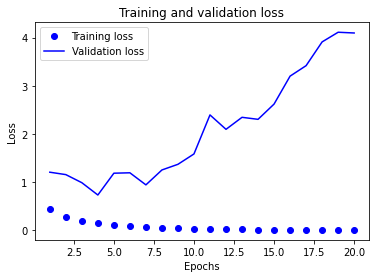

In [ ]:
history_dict = history.history
history_dict.keys()


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

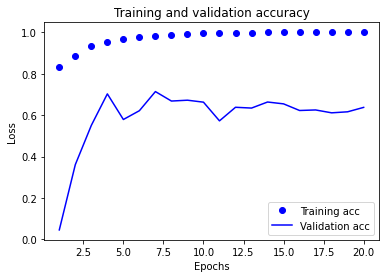

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Let's compare to the Keras dataset:

NOtice that, we could directly use the function `sequences_to_matrix` to obtain the BoW from binarized corpus:

In [ ]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)

# Extract binary BoW features
x_train = tok.sequences_to_matrix(train_data, mode='binary')
x_test = tok.sequences_to_matrix(test_data, mode='binary')
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

history_dict = history.history
history_dict.keys()




Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.5179 - binary_accuracy: 0.7887 - val_loss: 0.4234 - val_binary_accuracy: 0.8413
Epoch 2/20
15000/15000 [==============================] - 2s 109us/step - loss: 0.3184 - binary_accuracy: 0.8999 - val_loss: 0.3154 - val_binary_accuracy: 0.8828
Epoch 3/20
15000/15000 [==============================] - 2s 109us/step - loss: 0.2321 - binary_accuracy: 0.9276 - val_loss: 0.3069 - val_binary_accuracy: 0.8754
Epoch 4/20
15000/15000 [==============================] - 2s 108us/step - loss: 0.1823 - binary_accuracy: 0.9429 - val_loss: 0.2741 - val_binary_accuracy: 0.8920
Epoch 5/20
15000/15000 [==============================] - 2s 110us/step - loss: 0.1504 - binary_accuracy: 0.9514 - val_loss: 0.2792 - val_binary_accuracy: 0.8892
Epoch 6/20
15000/15000 [==============================] - 2s 108us/step - loss: 0.1227 - binary_accuracy: 0.9621 - val_loss: 0.3050 - val_bi

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

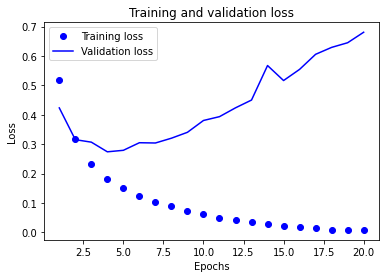

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


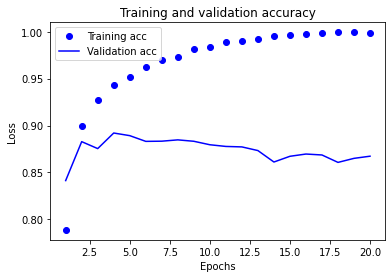

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# So what happened?

As you can see, the val loss curves with Keras data has much higher (~87%) accuracy than the one we used.

__The reason is that we assumed the data is shuffled!__

If you revise the get_texts function we implemented, it takes all the class data in sequence. 

Our train/val split did not contain any shuffling.

To fix this, we could manually shuffle:

```
VALIDATION_SPLIT = 0.4 # corresponds to 10,000 samples out of 25,000

indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]
nb_validation_samples = int(VALIDATION_SPLIT * x_train.shape[0])

partial_x_train = train_data[:-nb_validation_samples]
partial_y_train = train_targets[:-nb_validation_samples]
x_val = train_data[-nb_validation_samples:]
y_val = train_targets[-nb_validation_samples:]

print('Number of positive and negative reviews in traing and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
```

Or we could use sklearn `train_test_split` function:

In [ ]:
trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)
# Extract binary BoW features
x_train = tok.sequences_to_matrix(train_data, mode='binary')
x_test = tok.sequences_to_matrix(test_data, mode='binary')
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

In [ ]:


model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 146us/step - loss: 0.4886 - binary_accuracy: 0.8187 - val_loss: 0.3660 - val_binary_accuracy: 0.8732
Epoch 2/20
15000/15000 [==============================] - 2s 126us/step - loss: 0.2840 - binary_accuracy: 0.9051 - val_loss: 0.3200 - val_binary_accuracy: 0.8719
Epoch 3/20
15000/15000 [==============================] - 2s 127us/step - loss: 0.2132 - binary_accuracy: 0.9261 - val_loss: 0.2939 - val_binary_accuracy: 0.8842
Epoch 4/20
15000/15000 [==============================] - 2s 125us/step - loss: 0.1680 - binary_accuracy: 0.9433 - val_loss: 0.3135 - val_binary_accuracy: 0.8760
Epoch 5/20
15000/15000 [==============================] - 2s 124us/step - loss: 0.1402 - binary_accuracy: 0.9537 - val_loss: 0.3332 - val_binary_accuracy: 0.8766
Epoch 6/20
15000/15000 [==============================] - 2s 122us/step - loss: 0.1143 - binary_accuracy: 0.9639 - val_loss: 0.3323 - val_bi

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

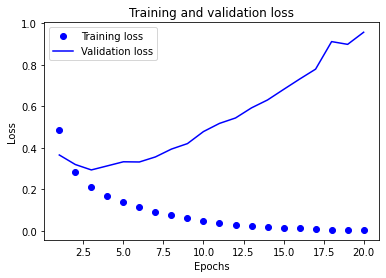

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

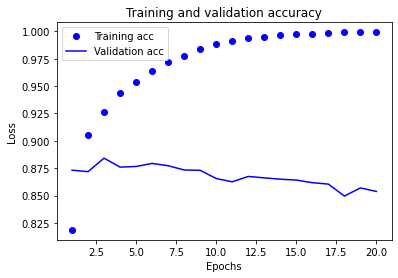

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Count/Freq features

## Count

In [ ]:
'''
trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)
'''
# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='count')
x_test = tok.texts_to_matrix(tst_texts, mode='count')
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)


In [ ]:
x_train

array([[ 0., 13.,  0., ...,  0.,  0.,  0.],
       [ 0.,  3.,  2., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0., 13.,  5., ...,  0.,  0.,  0.],
       [ 0.,  6.,  1., ...,  0.,  0.,  0.],
       [ 0., 19.,  0., ...,  0.,  0.,  0.]])

In [ ]:

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 130us/step - loss: 0.4968 - binary_accuracy: 0.8015 - val_loss: 0.3833 - val_binary_accuracy: 0.8666
Epoch 2/20
15000/15000 [==============================] - 1s 99us/step - loss: 0.2965 - binary_accuracy: 0.9026 - val_loss: 0.3106 - val_binary_accuracy: 0.8842
Epoch 3/20
15000/15000 [==============================] - 1s 99us/step - loss: 0.2196 - binary_accuracy: 0.9265 - val_loss: 0.3016 - val_binary_accuracy: 0.8871
Epoch 4/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.1767 - binary_accuracy: 0.9405 - val_loss: 0.3086 - val_binary_accuracy: 0.8845
Epoch 5/20
15000/15000 [==============================] - 1s 100us/step - loss: 0.1448 - binary_accuracy: 0.9533 - val_loss: 0.3411 - val_binary_accuracy: 0.8767
Epoch 6/20
15000/15000 [==============================] - 1s 99us/step - loss: 0.1218 - binary_accuracy: 0.9609 - val_loss: 0.3525 - val_binary

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

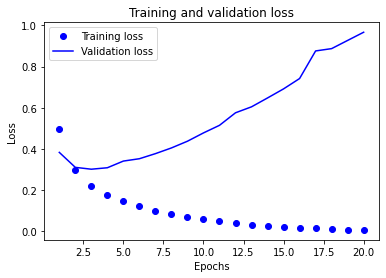

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

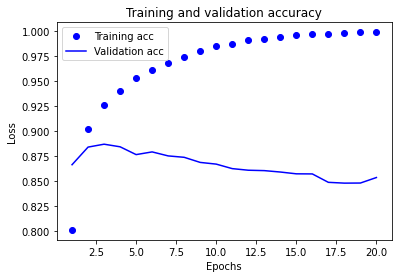

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As you can see above, the counts are not normalized values, which is not good for the NN (neurons activations prefer normalized values, however, for Dense and Relu it makes no big difference).

However, making just unnormalized counts is the same as binary BoW, since high frequency words will dominate the vector, specially that it's very sparse, causing quick overfitting. In other words, important low freq words are discarded. This can be treated with TF-IDF, or at least by normalizing, so the network might undersand that low frequencies have special importance.

In all cases, let's try to normalize into freq and see the differene:

## Freq

In [ ]:
'''
trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)
'''
# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='freq')
x_test = tok.texts_to_matrix(tst_texts, mode='freq')
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

In [ ]:
x_train

array([[0.        , 0.09090909, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.09895833, 0.015625  , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.08176101, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.08737864, 0.00485437, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01666667, 0.03333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06024096, 0.03313253, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 100us/step - loss: 0.6899 - binary_accuracy: 0.5448 - val_loss: 0.6858 - val_binary_accuracy: 0.7926
Epoch 2/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.6795 - binary_accuracy: 0.7297 - val_loss: 0.6736 - val_binary_accuracy: 0.6127
Epoch 3/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.6630 - binary_accuracy: 0.7353 - val_loss: 0.6552 - val_binary_accuracy: 0.7017
Epoch 4/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.6401 - binary_accuracy: 0.7746 - val_loss: 0.6311 - val_binary_accuracy: 0.8238
Epoch 5/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.6116 - binary_accuracy: 0.8211 - val_loss: 0.6031 - val_binary_accuracy: 0.7718
Epoch 6/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.5784 - binary_accuracy: 0.8299 - val_loss: 0.5700 - val_binary_

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

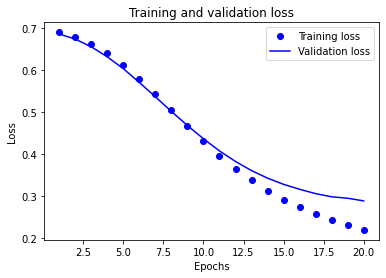

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

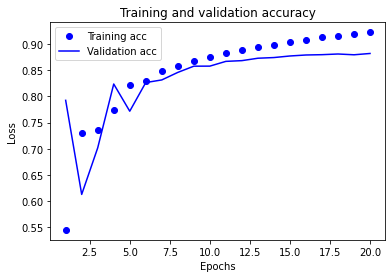

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As you can see, normalizing the counts correctly has a good effect to delay the overfitting. Even at the max epoch, we got higher acc (88%)

### TF-IDF features

In [ ]:
'''
trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)
'''
# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='tfidf')
x_test = tok.texts_to_matrix(tst_texts, mode='tfidf')
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

In [ ]:
x_train

array([[ 0.        , 31.87415358,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 42.6780341 ,  1.97049033, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 38.57203294,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , 42.09303767,  0.9389492 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 10.81979828,  1.58977919, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 43.2330172 ,  3.19045105, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:

#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 206us/step - loss: 0.4476 - binary_accuracy: 0.8013 - val_loss: 0.3374 - val_binary_accuracy: 0.8718
Epoch 2/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.2161 - binary_accuracy: 0.9251 - val_loss: 0.3103 - val_binary_accuracy: 0.8812
Epoch 3/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.1382 - binary_accuracy: 0.9559 - val_loss: 0.3452 - val_binary_accuracy: 0.8733
Epoch 4/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.0894 - binary_accuracy: 0.9742 - val_loss: 0.3915 - val_binary_accuracy: 0.8684
Epoch 5/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.0610 - binary_accuracy: 0.9843 - val_loss: 0.4332 - val_binary_accuracy: 0.8682
Epoch 6/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.0392 - binary_accuracy: 0.9912 - val_loss: 0.5061 - val_binary_

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

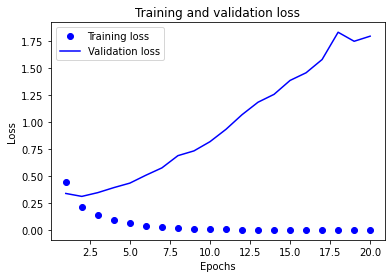

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

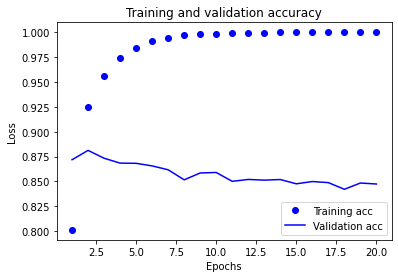

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

__TF-IDF not normalized?__

In the above setting, TFIDF in keras texts_to_matrix produce non normalized values. This is because the IDF ~= 1/DF, but log(1+DF) (for math convenience the log is calculated): http://www.tfidf.com/

https://github.com/keras-team/keras/issues/2974

For this bug, it's better to use sklearn TfidfVectorizer

__Using sklearn TfidfVectorizer__


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(trn_texts+tst_texts)


x_train = vectorizer.transform(trn_texts)
x_test =vectorizer.transform(tst_texts)
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')


In [ ]:
x_train.shape

(25000, 140805)

In [ ]:
print(x_train[0].toarray().max())
print(x_train[0].toarray().min())

0.2574521557691431
0.0


Now we get normalized values, but on ALL vocab.

If we try toarray we will get out of mem!

__How to limit the vocab?__

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vocab_sz = 10000
vectorizer = TfidfVectorizer(max_features=vocab_sz)
# tokenize and build vocab
vectorizer.fit(trn_texts+tst_texts)


x_train = vectorizer.transform(trn_texts)
x_test =vectorizer.transform(tst_texts)
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

In [ ]:

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 108us/step - loss: 0.6545 - binary_accuracy: 0.8026 - val_loss: 0.6089 - val_binary_accuracy: 0.8663
Epoch 2/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.5550 - binary_accuracy: 0.8837 - val_loss: 0.5177 - val_binary_accuracy: 0.8674
Epoch 3/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.4522 - binary_accuracy: 0.8982 - val_loss: 0.4317 - val_binary_accuracy: 0.8772
Epoch 4/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.3613 - binary_accuracy: 0.9096 - val_loss: 0.3643 - val_binary_accuracy: 0.8807
Epoch 5/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.2905 - binary_accuracy: 0.9211 - val_loss: 0.3191 - val_binary_accuracy: 0.8840
Epoch 6/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.2387 - binary_accuracy: 0.9297 - val_loss: 0.2916 - val_bi

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

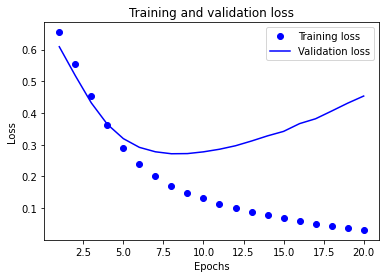

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

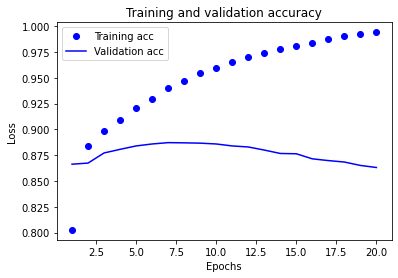

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Let's see the effect without text cleaning steps:

In [ ]:

trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

#trn_texts = normalize_corpus(trn_texts)
#tst_texts = normalize_corpus(tst_texts)

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)

# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='binary')
x_test = tok.texts_to_matrix(tst_texts, mode='binary')
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.5280 - binary_accuracy: 0.7893 - val_loss: 0.4041 - val_binary_accuracy: 0.8765
Epoch 2/20
15000/15000 [==============================] - 1s 85us/step - loss: 0.3243 - binary_accuracy: 0.9004 - val_loss: 0.3151 - val_binary_accuracy: 0.8885
Epoch 3/20
15000/15000 [==============================] - 1s 84us/step - loss: 0.2369 - binary_accuracy: 0.9259 - val_loss: 0.2837 - val_binary_accuracy: 0.8905
Epoch 4/20
15000/15000 [==============================] - 1s 87us/step - loss: 0.1896 - binary_accuracy: 0.9382 - val_loss: 0.2795 - val_binary_accuracy: 0.8890
Epoch 5/20
15000/15000 [==============================] - 1s 86us/step - loss: 0.1541 - binary_accuracy: 0.9527 - val_loss: 0.2834 - val_binary_accuracy: 0.8882
Epoch 6/20
15000/15000 [==============================] - 1s 86us/step - loss: 0.1273 - binary_accuracy: 0.9613 - val_loss: 0.3054 - val_binary_a

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

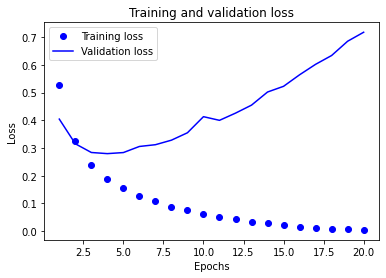

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

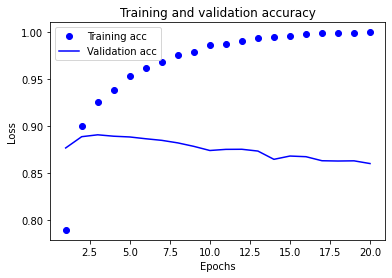

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As you can see, the effect is minimal, but the val curve a bit smoother in case of text clean-up

# Why?

We already limit the vocab to the most frequent 10K words, and we use BoW features, so cleanining up the text has minimal effect, since the words context is neglected (high frequent words are likely to always be scored no matter different morphologies might be missed sometimes).

For sequence models for example with word embeddings (as we will see), the context of the word will have strong effect, so the clean up step will have more importance.

# Bag-of-word Vectors:

Th above model suffers two issues:

1- Sequence info is lost. We will treat that later with sequence models

2- __Sparsity__: the input scalars represent words indices. Those are sparse, and do not include any info about the word (is it a verb, is it a noun, is it a sarcastic word,....etc). Also, this input is very sparse, where in a sentence, we only have few words of the vocab.

Thus, we use `Embedding` layer, that will encode _latent_ factors of the word features. In the current setup, we will _learn_ what those latent features are during training. 

## Embedding

The input scalars represent words indices. Those are sparse, and do not include any info about the word (is it a verb, is it a noun, is it a sarcastic word,....etc). Also, this input is very sparse, where in a sentence, we only have few words of the vocab.

Thus, we use `Embedding` layer, that will encode _latent_ factors of the word features. In the current setup, we will _learn_ what those latent features are during training. 


# Word Embedding
A word embedding is a class of approaches for representing words and documents using a
dense vector representation. It is an improvement over more the traditional bag-of-word model
encoding schemes where large sparse vectors were used to represent each word or to score each
word within a vector to represent an entire vocabulary. These representations were sparse
because the vocabularies were vast and a given word or document would be represented by a
large vector comprised mostly of zero values.
Instead, in an embedding, words are represented by dense vectors where a vector represents
the projection of the word into a continuous vector space. The position of a word within the
vector space is learned from text and is based on the words that surround the word when it is
used. The position of a word in the learned vector space is referred to as its embedding. Two
popular examples of methods of learning word embeddings from text include:

- Word2Vec.
- GloVe.
In addition to these carefully designed methods, a word embedding can be learned as part
of a deep learning model. This can be a slower approach, but tailors the model to a specic
training dataset.

# Keras Embedding Layer
Keras offers an Embedding layer that can be used for neural networks on text data. 

You can think of it as:
- LUT
- Weight Matrix: n_vocab x emb_sz

It requires that the input data be integer encoded, so that each word is represented by a unique integer.

This data preparation step can be performed using the Tokenizer API also provided with Keras.


The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset. 

It is a layer that can be used in a variety of ways, such as:

- _From scratch embeddings_ It can be used alone to learn a word embedding that can be saved and used in another model later.

- _Learnable embeddings_ It can be used as part of a deep learning model where the embedding is learned along with the model itself.

- _Pre-trained embeddings_ It can be used to load a pre-trained word embedding model, a type of transfer learning. This can be mixed with learnable embeddings, where those weights are later updated or frozen as part of the larger model.


The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:
- input dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.

- output dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.

-  input length: This is the length of input sequences, as you would dene for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [ ]:
from keras.layers import Embedding
e = Embedding(200, 32, input_length=50)

The Embedding layer has weights that are learned. If you save your model to file, this will include weights for the Embedding layer. 

The output of the Embedding layer is a 2D vector with one embedding for each word in the input sequence of words (input document). 

If you wish to connect a Dense layer directly to an Embedding layer, you must first flatten the 2D output matrix to a 1D vector using the Flatten layer. 

Now, let's see how we can use an Embedding layer in practice.

# Example

we will look at how we can learn a word embedding while setting a neural
network on a text classifiation problem. We will define a small problem where we have 10 text documents, each with a comment about a piece of work a student submitted. 

Each text document is classified as positive 1 or negative 0. This is a simple sentiment analysis problem.
First, we will dene the documents and their class labels.

Keras provides the one hot() function that creates a
hash of each word as an efficient integer encoding. We will estimate the vocabulary size of 50,
which is much larger than needed to reduce the probability of collisions from the hash function.

In [ ]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
# define documents
docs = ['Well done!',
'Good work','Great effort',
'nice work',
'Excellent!',
'Weak',
'Poor effort!',
'not good',
'poor work',
'Could have done better.']
# define class labels
labels = [1,1,1,1,1,0,0,0,0,0]
# integer encode the documents
#vocab_size = 50

#encoded_docs = [one_hot(d, vocab_size) for d in docs]
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)

print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
model.summary()
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

[[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
[[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
[[ 6  2  0  0]
 [ 3  1  0  0]
 [ 7  4  0  0]
 [ 8  1  0  0]
 [ 9  0  0  0]
 [10  0  0  0]
 [ 5  4  0  0]
 [11  3  0  0]
 [ 5  1  0  0]
 [12 13  2 14]]
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4, 8)              120       
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Accuracy: 89.999998


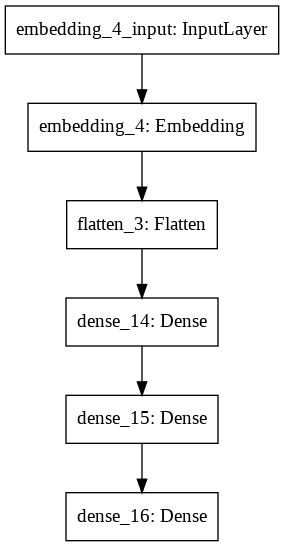

In [ ]:
emb_sz = 50
n_latent_factors = min(n_categories//2, emb_sz)
model = models.Sequential()
model.add(layers.Embedding(vocab_sz+1, n_latent_factors, input_length=vocab_sz))
model.add(layers.Flatten())
model.add(layers.Dense(emb_sz, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
plot_model(model)


In [ ]:

vocab_sz = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_sz)

tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)

# Extract binary BoW features
x_train = tok.sequences_to_matrix(train_data, mode='binary')
x_val = tok.sequences_to_matrix(test_data, mode='binary')
y_train = np.asarray(train_labels).astype('float32')
y_val = np.asarray(test_labels).astype('float32')

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 14s 577us/step - loss: 0.9382 - binary_accuracy: 0.5034 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 2/20
25000/25000 [==============================] - 14s 568us/step - loss: 0.6978 - binary_accuracy: 0.5014 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 3/20
25000/25000 [==============================] - 14s 568us/step - loss: 0.6932 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 4/20
25000/25000 [==============================] - 14s 568us/step - loss: 0.6932 - binary_accuracy: 0.4990 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 5/20
25000/25000 [==============================] - 14s 566us/step - loss: 0.6932 - binary_accuracy: 0.4943 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 6/20
25000/25000 [==============================] - 14s 569us/step - loss: 0.6932 - binary_accuracy: 0.5000 - val_loss: 0.6931 - 

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

# What happened?

In the above model, we encode the word feature as:
- 1--> word exists in the sentence
- 0 --> word doesnt exist in the sentence

So we don't have word index as feature anymore! In other words, the input to Embedding layer is invalid, since the Embedding layer can only be indexed with word index

__What do we do?__

We need to feed actual word indices. In other words, we need to convert back the binary features into sequence features.

__`pad_sequences`__

Now since we have a `Dense` layer in the model, we need to have fixed size input. We use keras `pad_sequences` to fill in to some `max_len`.

# BoW vectors model:

__This is still a BoW model!__

Note that, although we now have inputs as words indices.

But at some point in the model, we merge them as ___soup___ of word vectors in the `Flatten` layer, followed by a merger `Dense` layer. This is just a weighted sum of the words vectors.




__PAD token: Embedding(vocab_sz+1, emb_sz)__

Notice that we put the size of Embedding table = vocab_sz+1 X emb_sz.

This is because we want to reserve extra entry in the table for the _PAD_ token. In our BoW model, we reserve that token index to be 0.

___This must be considered in the tokenizer__

The tokenizer must reserve a token for the PAD token. It could be 0 or any other token. In all cases, it must not be used for any other word.

Keras `Embedding` is indifferent to the value of the reserved PAD token (0 or otherwise). It just needs extra value for the number of rows.

Without this vocab_sz+1 rows, we will have values of words indices = 1..vocab_sz + 0, so vocab_sz+1 values, which might cause run time error since we don't have entry for the PAD token.

In [ ]:

vocab_size = 10000
(x_train, y_train), (x_val, y_val) = imdb.load_data(num_words=vocab_size)

y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')


max_length = 100
x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_val = pad_sequences(x_val, maxlen=max_length, padding='post')


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)







In [ ]:
n_latent_factors = 25
model = models.Sequential()
model.add(layers.Embedding(vocab_sz+1, n_latent_factors, input_length=max_length))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 25)           250025    
_________________________________________________________________
flatten_4 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                40016     
_________________________________________________________________
dense_18 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 290,330
Trainable params: 290,330
Non-trainable params: 0
_________________________________________________________________


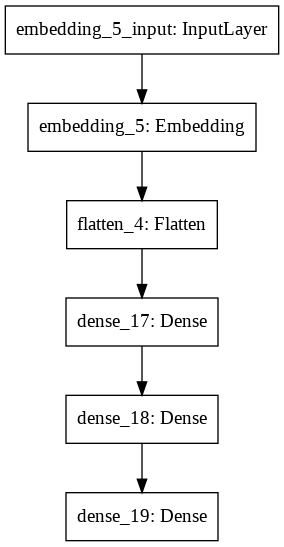

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 0s 16us/step - loss: 0.6896 - binary_accuracy: 0.5453 - val_loss: 0.6744 - val_binary_accuracy: 0.5914
Epoch 2/20
15000/15000 [==============================] - 0s 8us/step - loss: 0.5726 - binary_accuracy: 0.7745 - val_loss: 0.4883 - val_binary_accuracy: 0.7980
Epoch 3/20
15000/15000 [==============================] - 0s 8us/step - loss: 0.3593 - binary_accuracy: 0.8736 - val_loss: 0.3918 - val_binary_accuracy: 0.8250
Epoch 4/20
15000/15000 [==============================] - 0s 8us/step - loss: 0.2470 - binary_accuracy: 0.9118 - val_loss: 0.3588 - val_binary_accuracy: 0.8412
Epoch 5/20
15000/15000 [==============================] - 0s 8us/step - loss: 0.1738 - binary_accuracy: 0.9432 - val_loss: 0.4178 - val_binary_accuracy: 0.8158
Epoch 6/20
15000/15000 [==============================] - 0s 8us/step - loss: 0.1141 - binary_accuracy: 0.9701 - val_loss: 0.3714 - val_binary_accura

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

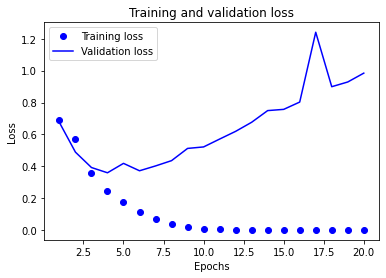

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

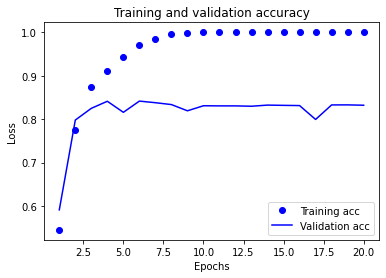

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Pros:
- We have dense word representation
- We somehow encode sequence information, since the inputs are now word positions, and their values=the word index at that position

# Cons:
- We still have BoW model. Although sequence is encoded in the input, but the info is lost later in the flatten layer --> ___RNN___
- It's hard for the `Dense` layer to capture ALL different patterns of the input, with each word appearing at different positions for different samples.
__We need some local features, that capture the word features, __wherever__ it occurs --> ___Conv1D___
- The model now is larger, with too many parameters to be learnt (word latent features). So it needs more data to learn words context. --> ___word2vec___

__We will treat the above issues one by one in the next lectures__

# Tips for Cleaning Text for Word Embedding
Recently, the field of natural language processing has been moving away from bag-of-word models and word encoding toward word embeddings. 

The benefit of word embeddings is that
they encode each word into a dense vector that captures something about its relative meaning within the training text. 

This means that variations of words like case, spelling, punctuation,
and so on will automatically be learned to be similar in the embedding space. 

In turn, this can mean that the amount of cleaning required from your text may be less and perhaps quite diffeerent to classical text cleaning. 

For example, __it may no-longer make sense to stem words or
remove punctuation for contractions.__

Tomas Mikolov is one of the developers of Word2Vec, a popular word embedding method. He suggests only very minimal text cleaning is required when learning a word embedding model. Below is his response when pressed with the question about how to best prepare text data for Word2Vec.

_There is no universal answer. It all depends on what you plan to use the vectors
for. In my experience, it is usually good to disconnect (or remove) punctuation from
words, and sometimes also convert all characters to lowercase. One can also replace
all numbers (possibly greater than some constant) with some single token such as .
All these pre-processing steps aim to reduce the vocabulary size without removing
any important content (which in some cases may not be true when you lowercase
certain words, ie. `Bush' is dierent than `bush', while `Another' has usually the
same sense as `another'). The smaller the vocabulary is, the lower is the memory
complexity, and the more robustly are the parameters for the words estimated. You
also have to pre-process the test data in the same way.
[...]
In short, you will understand all this much better if you will run experiments.
| Tomas Mikolov, word2vec-toolkit: google groups thread., 2015.
https://goo.gl/KtDGst_

# Pre-trained word Embeddings

In the above setting, we used a _learnable_ `Embedding` layer, which updates its ___randomly___ initialized weights, from the task at hand.

Another approach would be to load some pre-trained word vectors, that are trained on some other useful task in NLP, and then use those pre-trained vectors to initialize our Embedding table vectors.

One of the popular pre-trained embeddings is _GloVe_

# Loading GloVe

The Keras Embedding layer can also use a word embedding learned elsewhere. It is common in the NLP to learn, save, and make freely available word
embeddings. For example, the researchers behind GloVe method provide a suite of pre-trained word embeddings on their website released under a public domain license.

__Load embeddings for your vocab__

We need to create a matrix of one embedding for each word in the training
dataset. We can do that by enumerating all unique words in the Tokenizer.word index and
locating the embedding weight vector from the loaded GloVe embedding. The result is a matrix
of weights only for words we will see during training.

```
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
```

Now we can dene our model, t, and evaluate it as before. The key dierence is that
the Embedding layer can be seeded with the GloVe word embedding weights. We chose the
100-dimensional version, therefore the Embedding layer must be dened with output dim set to
100. Finally, we do not want to update the learned word weights in this model, therefore we
will set the trainable attribute for the model to be False.

```
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)
```

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2020-06-06 11:52:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-06-06 11:52:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-06 11:52:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
#!unzip glove.6B.zip.1

Archive:  glove.6B.zip.1
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
# define documents
docs = ['Well done!',
'Good work',
'Great effort',
'nice work',
'Excellent!',
'Weak',
'Poor effort!',
'not good',
'poor work',
'Could have done better.']
# define class labels
labels = [1,1,1,1,1,0,0,0,0,0]
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt', mode='rt', encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
model.summary()
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

[[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
[[ 6  2  0  0]
 [ 3  1  0  0]
 [ 7  4  0  0]
 [ 8  1  0  0]
 [ 9  0  0  0]
 [10  0  0  0]
 [ 5  4  0  0]
 [11  3  0  0]
 [ 5  1  0  0]
 [12 13  2 14]]
Loaded 400000 word vectors.
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 4, 100)            1500      
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 401       
Total params: 1,901
Trainable params: 401
Non-trainable params: 1,500
_________________________________________________________________
Accuracy: 100.000000


# BoW vectors with GloVe Embeddings

In [ ]:

vocab_size = 10000
(x_train, y_train), (x_val, y_val) = imdb.load_data(num_words=vocab_size)

y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')


max_length = 100
x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_val = pad_sequences(x_val, maxlen=max_length, padding='post')


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)







In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt', mode='rt', encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)

Loaded 400000 word vectors.


In [ ]:
n_latent_factors = 100
model = models.Sequential()
model.add(layers.Embedding(vocab_sz, n_latent_factors, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 1,160,305
Trainable params: 160,305
Non-trainable params: 1,000,000
_________________________________________________________________


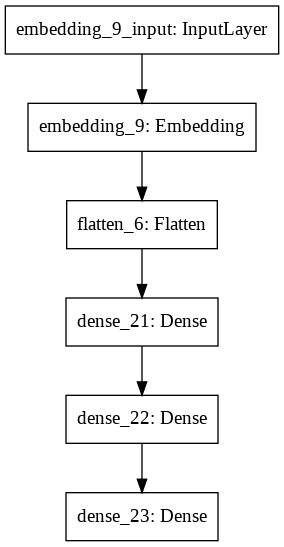

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 0s 15us/step - loss: 0.6969 - binary_accuracy: 0.5256 - val_loss: 0.6904 - val_binary_accuracy: 0.5336
Epoch 2/20
15000/15000 [==============================] - 0s 9us/step - loss: 0.6779 - binary_accuracy: 0.5715 - val_loss: 0.6906 - val_binary_accuracy: 0.5311
Epoch 3/20
15000/15000 [==============================] - 0s 9us/step - loss: 0.6576 - binary_accuracy: 0.6023 - val_loss: 0.6942 - val_binary_accuracy: 0.5408
Epoch 4/20
15000/15000 [==============================] - 0s 8us/step - loss: 0.6398 - binary_accuracy: 0.6289 - val_loss: 0.7007 - val_binary_accuracy: 0.5498
Epoch 5/20
15000/15000 [==============================] - 0s 8us/step - loss: 0.6216 - binary_accuracy: 0.6553 - val_loss: 0.7383 - val_binary_accuracy: 0.5326
Epoch 6/20
15000/15000 [==============================] - 0s 9us/step - loss: 0.5983 - binary_accuracy: 0.6745 - val_loss: 0.7223 - val_binary_accura

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

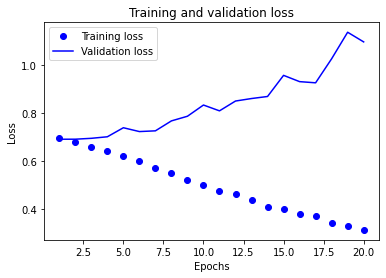

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

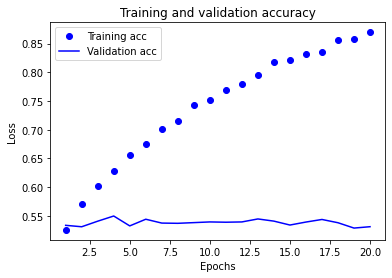

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Make trainable

In [ ]:
n_latent_factors = 100
model = models.Sequential()
model.add(layers.Embedding(vocab_sz, n_latent_factors, weights=[embedding_matrix], input_length=max_length, trainable=True))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_8 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 1,321,121
Trainable params: 1,321,121
Non-trainable params: 0
_________________________________________________________________


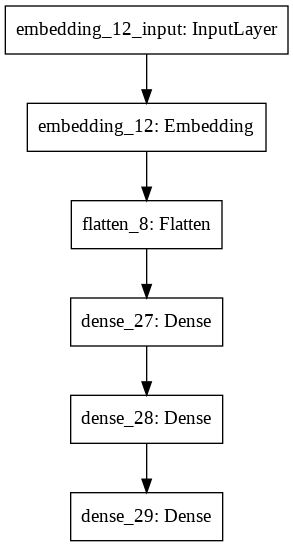

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 0s 19us/step - loss: 0.6978 - binary_accuracy: 0.5161 - val_loss: 0.6914 - val_binary_accuracy: 0.5356
Epoch 2/20
15000/15000 [==============================] - 0s 10us/step - loss: 0.6636 - binary_accuracy: 0.6006 - val_loss: 0.7018 - val_binary_accuracy: 0.5461
Epoch 3/20
15000/15000 [==============================] - 0s 10us/step - loss: 0.6072 - binary_accuracy: 0.6684 - val_loss: 0.6335 - val_binary_accuracy: 0.6380
Epoch 4/20
15000/15000 [==============================] - 0s 10us/step - loss: 0.5206 - binary_accuracy: 0.7477 - val_loss: 0.5886 - val_binary_accuracy: 0.6832
Epoch 5/20
15000/15000 [==============================] - 0s 10us/step - loss: 0.4300 - binary_accuracy: 0.8065 - val_loss: 0.5245 - val_binary_accuracy: 0.7370
Epoch 6/20
15000/15000 [==============================] - 0s 10us/step - loss: 0.3420 - binary_accuracy: 0.8555 - val_loss: 0.5181 - val_binary_a

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

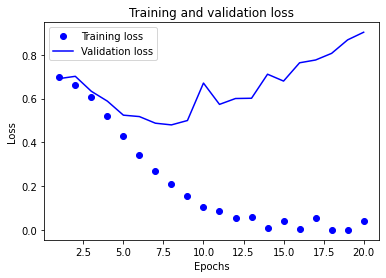

In [ ]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

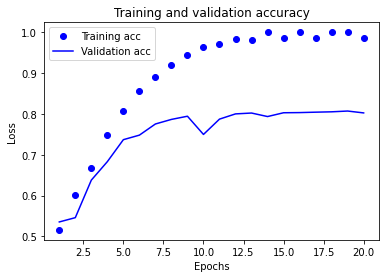

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()